In [2]:
# Import libraries
using Turing
using LinearAlgebra
using Distributions
using MultivariateStats
import MultivariateStats: reconstruct
using GaussianProcesses
using StatsBase
using Statistics
using Suppressor
using JLD2
using CSV
using DataFrames, DataFramesMeta
using SplitApplyCombine
using KernelFunctions
using MCMCChains
using PyCall
using PyPlot
using Printf
import PyCall.pyfunction
using Missings

os = pyimport("os")
pyimport("scienceplots")
np = pyimport("numpy")


PyCall.pygui(:tk)

FONTSIZE=20.5;

In [3]:
using PrettyTables

In [4]:
#####################################################################################################################
#####################################################################################################################
#####################################################################################################################
###############################                Parameter Learning Tables             ###########################
#####################################################################################################################
#####################################################################################################################
#####################################################################################################################

In [5]:
function get_up_low(post_dict, upper_quant, lower_quant, γ0_is_log)
    p = [upper_quant,lower_quant]
    quantiles = zeros(19, 6, 2)
    sorted_keys = sort(collect(keys(post_dict)))
    # Adjust for when gamma_0 is considered on the log scale

        for i in 1:19
            mat = post_dict[ sorted_keys[i] ]
            quantiles[i, 1,:] = quantile( mat[:,1], p )
            quantiles[i, 2,:] = quantile( mat[:,2], p )
            quantiles[i, 3,:] = quantile( mat[:,3], p )
            quantiles[i, 4,:] = quantile( mat[:,4], p )
            quantiles[i, 5,:] = (γ0_is_log) ? quantile( np.log(mat[:,5]), p ) : quantile( mat[:,5], p )
            quantiles[i, 6,:] = quantile( mat[:,6], p )
        end

    return quantiles
end

Realizations = [string(i) for i in 1:100];
cal_years = collect(range(2015,step=15,length=20));

# Load the present day posteriors 
gamma_0_is_log = true
present_posterior = np.load("../Data/Training_Data/posterior_samples_All_Combined.npy");

# Compute upper and lower quantile bounds for present day posteriors
present_bounds = []
present_widths = []
for i in 1:6
    lower = (i == 5 && gamma_0_is_log) ? quantile(np.log(present_posterior[:,i]), 0.05) : quantile(present_posterior[:,i], 0.05)
    upper = (i == 5 && gamma_0_is_log) ? quantile(np.log(present_posterior[:,i]), 0.95) : quantile(present_posterior[:,i], 0.95)
    #lower = round.(lower, digits=3)
    #upper = round.(upper, digits=3)
    push!(present_bounds, (lower,upper))
    push!(present_widths, upper - lower)
end
present_bounds = reshape(present_bounds, 1, :)
present_widths = reshape(present_widths, 1, :);


# Change to wherever your posterior dictionaries are located
path_to_posteriors = "../Data/Posterior_Data"

# Initialize empty vectors to hold interval bounds and widths 
all_widths = zeros(length(Realizations),19,6)
all_bounds = zeros(length(Realizations), 19, 6, 2)


# Loop to calculate quantiles and credible interval widths
    for (iter, r) in enumerate(Realizations)
        post = JLD2.load("$(path_to_posteriors)/R_$(r)_Posterior_Dict.jld2", "post_data")
        cred_int_90_up_low = get_up_low(post, 0.95, 0.05,gamma_0_is_log)
        all_bounds[iter, :, :, :] = cred_int_90_up_low
        all_widths[iter,:,:] = cred_int_90_up_low[:,:,1] .- cred_int_90_up_low[:,:,2]
    end
# The average 5th percentile and and 95th percentiles of the six MALI parameters across all trajectories over the 19 years of calibration
avg_bounds = mean(all_bounds,dims=1)
avg_bounds = dropdims(avg_bounds, dims=1)
#avg_bounds = round.(avg_bounds, digits=3)
# The average 90% credible interval widths of the six MALI parameters across all trajectories for each of the 19 years of calibration
avg_widths = mean(all_widths,dims=1)
avg_widths = dropdims(avg_widths, dims=1)


# The 17% and 83% quantiles of the 90% cred int widths of the six MALI parameters across all trajectories for each of the 19 years of calibration
width_variation_interval = np.quantile(all_widths, 0.83,axis=0) .- np.quantile(all_widths, 0.17,axis=0)
#width_variation_interval = round.(width_variation_interval,digits=3)

# Store the bounds as tuples in one matrix
bounds_as_tuples = fill((0.0,0.0),(19,6))
for i in 1:19
    for j in 1:6
        bounds_as_tuples[i,j] = (avg_bounds[i,j,2], avg_bounds[i,j,1])
    end
end
# Add the 2015 90% credible interval bounds
bounds_w_present = vcat(present_bounds, bounds_as_tuples);

# Add the 2015 90% credible widths
widths_w_present = vcat(present_widths, avg_widths);
#widths_w_present = round.(widths_w_present,digits=3)

# Add the years of calibration as another column
bounds_w_years = hcat(cal_years, bounds_w_present)
widths_w_years = hcat(cal_years, widths_w_present)
width_var_w_years = hcat(cal_years[2:end], width_variation_interval)





19×7 Matrix{Float64}:
 2030.0  2029.61  0.0112981  0.0116831  0.0164241  0.283182  0.473103
 2045.0  4980.55  0.0222682  0.0566261  0.0564186  0.647553  1.00226
 2060.0  5029.58  0.0232646  0.0679319  0.0609713  0.546037  1.78124
 2075.0  5886.66  0.0278012  0.0811787  0.0655848  0.357529  3.26106
 2090.0  6233.56  0.0349764  0.0772355  0.0703233  0.347599  4.55914
 2105.0  6406.98  0.0463231  0.106352   0.0703194  0.486223  5.54654
 2120.0  6184.05  0.0511391  0.111838   0.0772804  0.402511  5.33145
 2135.0  5370.27  0.057369   0.11372    0.0741595  0.393679  4.80534
 2150.0  5836.93  0.0553297  0.11905    0.0834563  0.382299  4.7311
 2165.0  7043.88  0.0573592  0.111035   0.0778574  0.538544  4.066
 2180.0  5667.74  0.0699948  0.103016   0.0708419  0.535289  3.8984
 2195.0  5543.1   0.0630178  0.0900316  0.0623848  0.33288   3.87008
 2210.0  5637.54  0.0530368  0.0645052  0.0669342  0.324623  4.62823
 2225.0  6327.31  0.023025   0.058801   0.0658794  0.275567  4.97608
 2240.0  6408.3

In [6]:
# Dataframe column names
names = ["Analysis Year","vmThresh","fricExp","mu_scale","stiff_scale","log(gamma_0)","melt_flux"]

# Covnert to datframe before saving to disc
params_df_bounds    = DataFrame(bounds_w_years, names)
params_df_widths    = DataFrame(widths_w_years, names)
params_df_width_var = DataFrame(width_var_w_years, names)

#Calculate total percent decrease of 90% cred interval width
pct_change = ((collect(params_df_widths[1,2:end]) .- collect(params_df_widths[20,2:end])) ./ collect(params_df_widths[1,2:end])) .* 100
#pct_change = round.(pct_change,digits=3)
# Make a 1×7 row: first element is label, then pct_change values
new_row = hcat("total_%_decrease", pct_change...)
# Convert to DataFrame with the same column names
new_df = DataFrame(new_row, names)
# Append to params_df_widths
append!(params_df_widths, new_df,promote=true)

# Making deepcopies to do some string formatting and rounding
rounded_bounds_df    =    deepcopy(params_df_bounds   )
rounded_widths_df    =    deepcopy(params_df_widths   )
rounded_width_var_df =    deepcopy(params_df_width_var);

In [7]:
# Rounding and formatting to look nice in the tables
for i in 2:7
    rounded_bounds_df[!, names[i]] = [
    string("(", @sprintf("%.3f", tup[1]), ", ", @sprintf("%.3f", tup[2]), ")")
    for tup in rounded_bounds_df[!, names[i]]    ]
    
    rounded_widths_df[!, names[i]] = [ @sprintf("%.3f",val) for val in rounded_widths_df[!, names[i]] ]
    rounded_width_var_df[!, names[i]] = [ @sprintf("%.3f",val) for val in rounded_width_var_df[!, names[i]] ]
end



# CSV.write("../Data/Parameter_Learning_Tables/CI_bounds_log-gamma0_$(gamma_0_is_log).csv",            rounded_bounds_df   )
# CSV.write("../Data/Parameter_Learning_Tables/CI_widths_log-gamma0_$(gamma_0_is_log).csv",            rounded_widths_df   )
# CSV.write("../Data/Parameter_Learning_Tables/CI_width_variation_log-gamma0_$(gamma_0_is_log).csv",   rounded_width_var_df)

In [8]:
# Converting the dataframe to latex table code
pretty_table(rounded_bounds_df; backend = Val(:latex))
pretty_table(rounded_widths_df; backend = Val(:latex))
pretty_table(rounded_width_var_df; backend = Val(:latex))

\begin{tabular}{rrrrrrr}
  \hline
  \textbf{Analysis Year} & \textbf{vmThresh} & \textbf{fricExp} & \textbf{mu\_scale} & \textbf{stiff\_scale} & \textbf{log(gamma\_0)} & \textbf{melt\_flux} \\
  \texttt{Any} & \texttt{String} & \texttt{String} & \texttt{String} & \texttt{String} & \texttt{String} & \texttt{String} \\\hline
  2015 & (109048.026, 143137.364) & (0.130, 0.302) & (0.834, 1.067) & (0.847, 1.053) & (9.315, 11.847) & (19.930, 50.410) \\
  2030 & (109324.065, 143104.858) & (0.134, 0.301) & (0.847, 1.060) & (0.851, 1.047) & (9.323, 11.790) & (20.002, 50.373) \\
  2045 & (109259.317, 143024.577) & (0.141, 0.300) & (0.849, 1.058) & (0.852, 1.043) & (9.355, 11.611) & (20.111, 50.290) \\
  2060 & (109399.580, 143042.460) & (0.142, 0.299) & (0.851, 1.058) & (0.854, 1.041) & (9.517, 11.317) & (20.204, 50.018) \\
  2075 & (109555.300, 143031.083) & (0.145, 0.299) & (0.851, 1.055) & (0.857, 1.039) & (9.717, 10.963) & (21.265, 49.385) \\
  2090 & (109834.116, 142987.982) & (0.145, 0.297)

In [11]:
##CALCULATING THE YEAR BY YEAR CHANGE IN UNCERTAINTY RANGES FOR EACH PARAMETER, AS WELL AS PERCENT CONTRIBUTION TO TOTAL LEARNING
##
cal_years = collect(range(2015,step=15,length=20))

Δ_param_width = zeros(20, 6)
Δ_param_width_pct = zeros(20, 6)

#Total learning from 2015 - 2300

# find row indices
total_idx1 = only(findall(x -> x == 2015, cal_years))
total_idx2 = only(findall(x -> x == 2300, cal_years))

# extract vectors (dropping year column)
present = collect(params_df_widths[total_idx1, :])[2:end]
final = collect(params_df_widths[total_idx2, :])[2:end]

# compute differences
total_diff = final .- present
Δ_param_width[20, :] = total_diff
#Δ_param_width_pct[20,:] .= 100.0

learn_periods = []

for i in 1:(length(cal_years)-1)
    yr1 = cal_years[i]
    yr2 = cal_years[i+1]

    # find row indices
    row_idx1 = only(findall(x -> x == yr1, cal_years))
    row_idx2 = only(findall(x -> x == yr2, cal_years))

    # extract vectors (dropping year column)
    row1 = collect(params_df_widths[row_idx1, :])[2:end]
    row2 = collect(params_df_widths[row_idx2, :])[2:end]

    # compute differences
    diff = row2 .- row1
    Δ_param_width[i, :] = diff
    Δ_param_width_pct[i, :] = (diff ./ total_diff) .* 100
    # Collect this learning period as string for datframe labels
    push!(learn_periods, "$(yr1) - $(yr2)")
end

# Add the total learning period
push!(learn_periods, "2015 - 2300")
width_change_mat = zeros(20,12)

# Put the parameter width changes and percent changes together param by param columnwise
for i in 1:6
    width_change_mat[:,(2*i)-1] = Δ_param_width[:,i]
    width_change_mat[:,(2*i)] = Δ_param_width_pct[:,i]
end
width_change_mat = round.(width_change_mat, digits=3)

param_names = ["LearningPeriod","ΔvmThresh","Δ_%_vmThresh","Δ_fricExp","Δ_%_fricExp","Δ_mu_scale","Δ_%_mu_scale","Δ_stiff_scale","Δ_%_stiff_scale","Δ_gamma0","Δ_%_gamma0","Δ_melt_flux","Δ_%_melt_flux"]
#sub_title_row = ["Change","Percent Change","Change","Percent Change","Change","Percent Change","Change","Percent Change","Change","Percent Change","Change","Percent Change"]

width_change_w_years = hcat(learn_periods, width_change_mat)
df_widths_yr_to_yr = DataFrame(width_change_w_years, param_names)
allowmissing!(df_widths_yr_to_yr)
df_widths_yr_to_yr[20, [3,5,7,9,11,13]] .= missing
rounded_widths_yr_to_yr_df = deepcopy(df_widths_yr_to_yr);

In [13]:
# Rounding and formatting to look nice in the tables
for i in 2:13
    rounded_widths_yr_to_yr_df[!,param_names[i]] = [ (typeof(val) == Float64) ? @sprintf("%.3f",val) : val for val in rounded_widths_yr_to_yr_df[!, param_names[i]] ]
end
# CSV.write("../Data/Parameter_Learning_Tables/yr_to_yr_change_in_widths_log_gamma0_$(gamma_0_is_log).csv", rounded_widths_yr_to_yr_df)

In [14]:
pretty_table(rounded_widths_yr_to_yr_df; backend = Val(:latex))

\begin{tabular}{rrrrrrrrrrrrr}
  \hline
  \textbf{LearningPeriod} & \textbf{ΔvmThresh} & \textbf{Δ\_\%\_vmThresh} & \textbf{Δ\_fricExp} & \textbf{Δ\_\%\_fricExp} & \textbf{Δ\_mu\_scale} & \textbf{Δ\_\%\_mu\_scale} & \textbf{Δ\_stiff\_scale} & \textbf{Δ\_\%\_stiff\_scale} & \textbf{Δ\_gamma0} & \textbf{Δ\_\%\_gamma0} & \textbf{Δ\_melt\_flux} & \textbf{Δ\_\%\_melt\_flux} \\
  \texttt{Any} & \texttt{String} & \texttt{String?} & \texttt{String} & \texttt{String?} & \texttt{String} & \texttt{String?} & \texttt{String} & \texttt{String?} & \texttt{String} & \texttt{String?} & \texttt{String} & \texttt{String?} \\\hline
  2015 - 2030 & -308.545 & 3.692 & -0.005 & 3.307 & -0.020 & 13.987 & -0.010 & 8.457 & -0.065 & 2.839 & -0.110 & 0.936 \\
  2030 - 2045 & -15.534 & 0.186 & -0.008 & 5.482 & -0.005 & 3.189 & -0.005 & 4.594 & -0.211 & 9.239 & -0.191 & 1.631 \\
  2045 - 2060 & -122.379 & 1.464 & -0.002 & 1.180 & -0.002 & 1.250 & -0.004 & 3.212 & -0.456 & 19.984 & -0.365 & 3.111 \\
  2060 - 2075 &

In [15]:
println(sum(df_widths_yr_to_yr[1:5, 11]) + sum(df_widths_yr_to_yr[6:13, 11]) + sum(df_widths_yr_to_yr[14:19, 11]))

99.99799999999999


In [17]:
cols = [3,5,7,9,11,13]
for (i,col) in enumerate(cols)
    println("$(param_names[2i+1]) decrease from 2015 to 2150: ")
    println(sum(df_widths_yr_to_yr[1:9, col]))
end

Δ_%_vmThresh decrease from 2015 to 2150: 
28.858
Δ_%_fricExp decrease from 2015 to 2150: 
26.74
Δ_%_mu_scale decrease from 2015 to 2150: 
44.349
Δ_%_stiff_scale decrease from 2015 to 2150: 
48.086000000000006
Δ_%_gamma0 decrease from 2015 to 2150: 
76.84400000000001
Δ_%_melt_flux decrease from 2015 to 2150: 
59.522000000000006


In [18]:
cols = [3,5,7,9,11,13]
for (i,col) in enumerate(cols)
    println("$(param_names[2i+1]) decrease from 2150 to 2300: ")
    println(sum(df_widths_yr_to_yr[10:19, col]))
end



Δ_%_vmThresh decrease from 2150 to 2300: 
71.141
Δ_%_fricExp decrease from 2150 to 2300: 
73.26100000000001
Δ_%_mu_scale decrease from 2150 to 2300: 
55.653999999999996
Δ_%_stiff_scale decrease from 2150 to 2300: 
51.915
Δ_%_gamma0 decrease from 2150 to 2300: 
23.153999999999996
Δ_%_melt_flux decrease from 2150 to 2300: 
40.477999999999994


In [19]:
cols = [3,5,7,9,11,13]
for (i,col) in enumerate(cols)
    println("$(param_names[2i+1]) decrease from 2015 to 2150: ")
    println(sum(df_widths_yr_to_yr[1:19, col]))
end

Δ_%_vmThresh decrease from 2015 to 2150: 
99.99900000000001
Δ_%_fricExp decrease from 2015 to 2150: 
100.001
Δ_%_mu_scale decrease from 2015 to 2150: 
100.003
Δ_%_stiff_scale decrease from 2015 to 2150: 
100.001
Δ_%_gamma0 decrease from 2015 to 2150: 
99.998
Δ_%_melt_flux decrease from 2015 to 2150: 
100.00000000000001


In [20]:
##CALCULATING THE YEAR BY YEAR CHANGE IN UNCERTAINTY RANGE STANDARD DEVIATION FOR EACH PARAMETER, AS WELL AS PERCENT CONTRIBUTION TO TOTAL CHANGE
##
cal_years = collect(range(2030,step=15,length=19))

Δ_width_var = zeros(18, 6)
Δ_width_var_pct = zeros(18, 6)

learn_periods = []

for i in 1:(length(cal_years)-1)
    yr1 = cal_years[i]
    yr2 = cal_years[i+1]

    # find row indices
    row_idx1 = only(findall(x -> x == yr1, cal_years))
    row_idx2 = only(findall(x -> x == yr2, cal_years))

    # extract vectors (dropping year column)
    row1 = collect(params_df_width_var[row_idx1, :])[2:end]
    row2 = collect(params_df_width_var[row_idx2, :])[2:end]

    # compute differences
    diff = row2 .- row1
    Δ_width_var[i, :] = round.(diff, sigdigits = 6)
    Δ_width_var_pct[i, :] = (diff ./ total_diff) .* 100
    # Collect this learning period as string for datframe labels
    push!(learn_periods, "$(yr1) - $(yr2)")
end
# Add the total learning period (2015 not included since multiple trajectories only began with 2030 caliobration onward)
width_variance_change = zeros(18,12)

# Put the parameter width changes and percent changes together param by param columnwise
for i in 1:6
    width_variance_change[:,(2*i)-1] = Δ_width_var[:,i]
    width_variance_change[:,(2*i)] = Δ_width_var_pct[:,i]
end
width_variance_change = round.(width_variance_change, digits=3)

names = ["LearningPeriod","ΔvmThresh","Δ_%_vmThresh","Δ_fricExp","Δ_%_fricExp","Δ_mu_scale","Δ_%_mu_scale","Δ_stiff_scale","Δ_%_stiff_scale","Δ_gamma0","Δ_%_gamma0","Δ_melt_flux","Δ_%_melt_flux"]
width_variance_w_years = hcat(learn_periods, width_variance_change)
df_width_variance_yr_to_yr = DataFrame(width_variance_w_years , names)
rounded_width_variance_yr_to_yr_df = deepcopy(df_width_variance_yr_to_yr);


In [21]:
# Rounding and formatting to look nice in the tables
for i in 2:13
    rounded_width_variance_yr_to_yr_df[!,names[i]] = [ (typeof(val) == Float64) ? @sprintf("%.3f",val) : val for val in rounded_width_variance_yr_to_yr_df[!, names[i]] ]
end
# CSV.write("../Data/Parameter_Learning_Tables/yr_to_yr_change_in_width_variation_log_gamma0_$(gamma_0_is_log).csv", rounded_width_variance_yr_to_yr_df)

In [22]:
pretty_table(rounded_width_variance_yr_to_yr_df; backend = Val(:latex))

\begin{tabular}{rrrrrrrrrrrrr}
  \hline
  \textbf{LearningPeriod} & \textbf{ΔvmThresh} & \textbf{Δ\_\%\_vmThresh} & \textbf{Δ\_fricExp} & \textbf{Δ\_\%\_fricExp} & \textbf{Δ\_mu\_scale} & \textbf{Δ\_\%\_mu\_scale} & \textbf{Δ\_stiff\_scale} & \textbf{Δ\_\%\_stiff\_scale} & \textbf{Δ\_gamma0} & \textbf{Δ\_\%\_gamma0} & \textbf{Δ\_melt\_flux} & \textbf{Δ\_\%\_melt\_flux} \\
  \texttt{Any} & \texttt{String} & \texttt{String} & \texttt{String} & \texttt{String} & \texttt{String} & \texttt{String} & \texttt{String} & \texttt{String} & \texttt{String} & \texttt{String} & \texttt{String} & \texttt{String} \\\hline
  2030 - 2045 & 2950.940 & -35.308 & 0.011 & -7.259 & 0.045 & -31.575 & 0.040 & -34.584 & 0.364 & -15.971 & 0.529 & -4.511 \\
  2045 - 2060 & 49.035 & -0.587 & 0.001 & -0.659 & 0.011 & -7.943 & 0.005 & -3.937 & -0.102 & 4.450 & 0.779 & -6.641 \\
  2060 - 2075 & 857.073 & -10.255 & 0.005 & -3.002 & 0.013 & -9.307 & 0.005 & -3.989 & -0.189 & 8.263 & 1.480 & -12.616 \\
  2075 - 2090 & 

(20,)
20,)
(20,)
(20,)
(20,)
(20,)


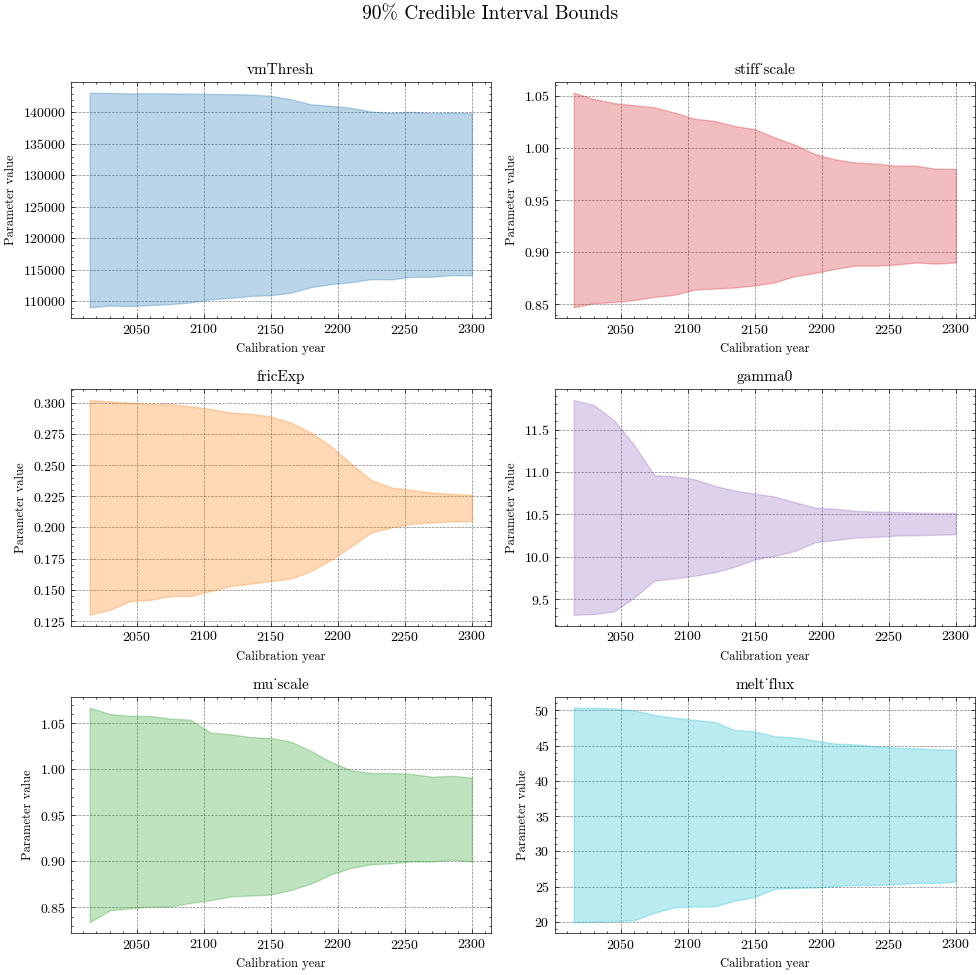

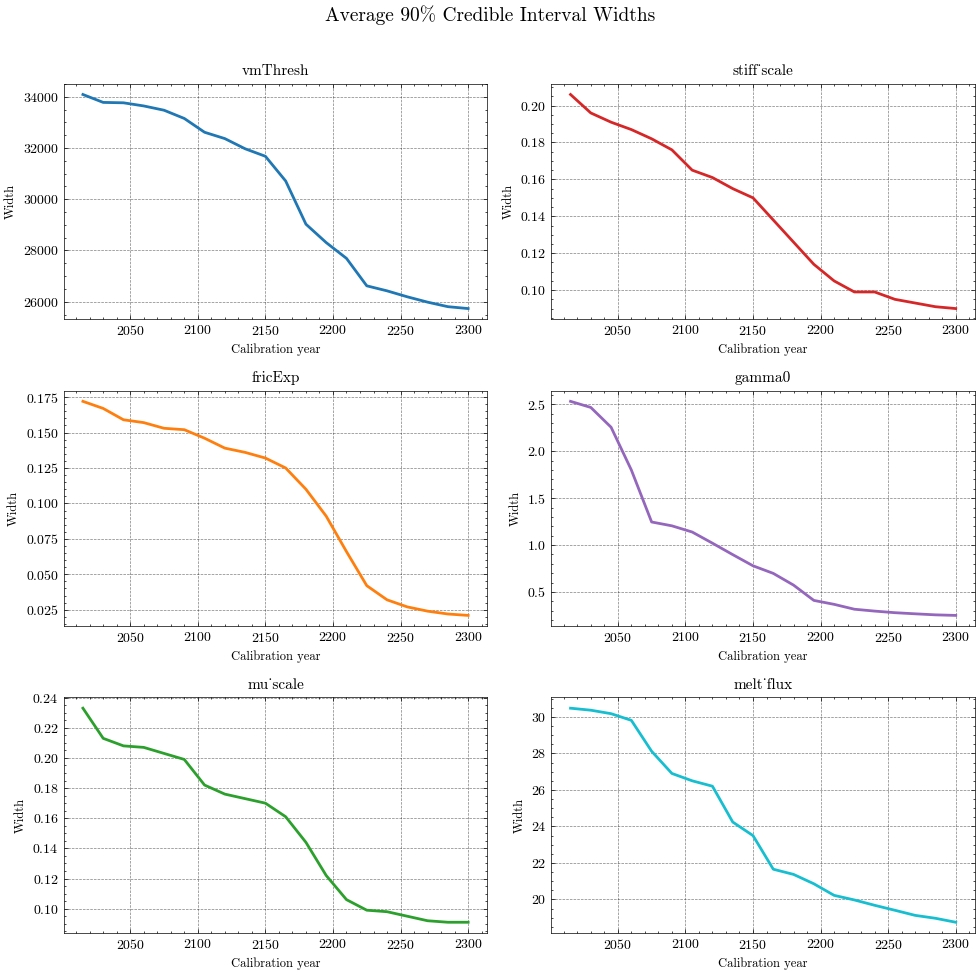

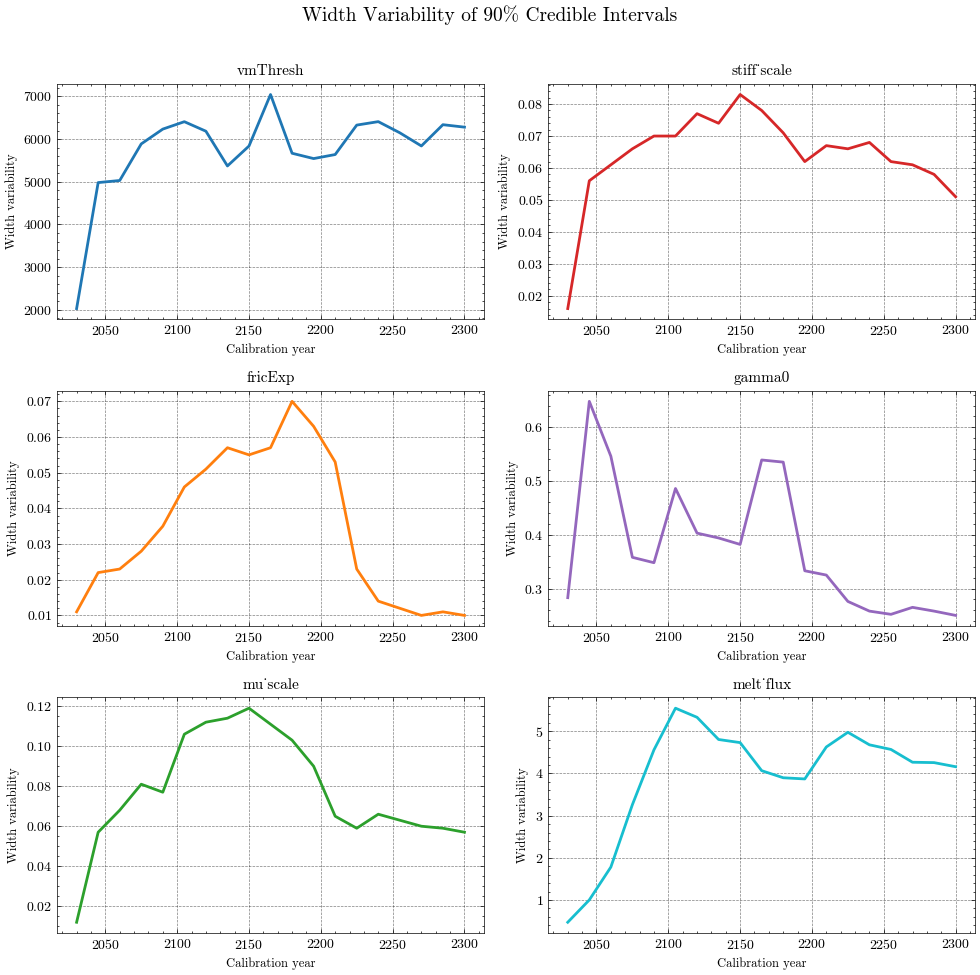

In [26]:
#Sanity Check

# Optional: science/academic plotting style if available
try
    pyimport("scienceplots")
    plt.style.use(["science", "no-latex", "grid"])
catch
    plt.style.use("seaborn-v0_8-colorblind")
end

# =============== CONFIGURATION ==================
base_path = "../Data/Parameter_Learning_Tables"
γ0_is_log = true

bounds_file = "$(base_path)/CI_bounds_log_gamma0_$(γ0_is_log).csv"
widths_file = "$(base_path)/CI_widths_log_gamma0_$(γ0_is_log).csv"
width_var_file = "$(base_path)/CI_width_variation_log_gamma0_$(γ0_is_log).csv"

param_names = ["vmThresh", "fricExp", "mu_scale", "stiff_scale", "gamma0", "melt_flux"]
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#17becf"]

# =============== LOAD DATA ==================
df_bounds = CSV.read(bounds_file, DataFrame)
df_widths = CSV.read(widths_file, DataFrame)
df_width_var = CSV.read(width_var_file, DataFrame)


plot_years = collect(range(2015, step=15,length=20))

# Helper function to parse tuple-like strings "(a,b)"
function parse_tuple_string(s::AbstractString)
    s = replace(s, r"[\(\)]" => "")
    nums = split(s, ",")
    return (parse(Float64, strip(nums[1])), parse(Float64, strip(nums[2])))
end

# =============== FIGURE 1: Credible Interval Bounds ==================
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

for (i, pname) in enumerate(param_names)
    bounds = parse_tuple_string.(String.(df_bounds[:, pname]))
    lowers = [b[1] for b in bounds]
    uppers = [b[2] for b in bounds]
    println(size(lowers))
    ax = axs[i]
    ax.fill_between(plot_years, lowers, uppers, color=colors[i], alpha=0.3)
    ax.set_title(pname, fontsize=11)
    ax.set_xlabel("Calibration year", fontsize=9)
    ax.set_ylabel("Parameter value", fontsize=9)
end

plt.suptitle("90% Credible Interval Bounds", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
#plt.savefig("../Figures/CI_bounds_log_gamma0_$(γ0_is_log).png", dpi=300)


# # =============== FIGURE 2: Credible Interval Widths ==================
fig2, axs2 = plt.subplots(3, 2, figsize=(10, 10))

#60
delete!(df_widths, findall(df_widths.Latest_calibration_year .== "total_%_decrease"))
for (i, pname) in enumerate(param_names)
    ax = axs2[i]
    ax.plot(plot_years, df_widths[:, pname], color=colors[i], lw=2)
    ax.set_title(pname, fontsize=11)
    ax.set_xlabel("Calibration year", fontsize=9)
    ax.set_ylabel("Width", fontsize=9)
end

plt.suptitle("Average 90% Credible Interval Widths", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
#plt.savefig("../Figures/CI_widths_log_gamma0_$(γ0_is_log).png", dpi=300)


# # =============== FIGURE 3: Width Variability ==================
fig3, axs3 = plt.subplots(3, 2, figsize=(10, 10))

for (i, pname) in enumerate(param_names)
    ax = axs3[i]
    ax.plot(plot_years[2:end], df_width_var[:, pname], color=colors[i], lw=2)
    ax.set_title(pname, fontsize=11)
    ax.set_xlabel("Calibration year", fontsize=9)
    ax.set_ylabel("Width variability", fontsize=9)
end

plt.suptitle("Width Variability of 90% Credible Intervals", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
#plt.savefig("../Figures/CI_width_variability_log_gamma0_$(γ0_is_log).png", dpi=300)

